In [1]:
import numpy as np
import pandas as pd
import volprice as vl
import matplotlib as mpl
import seaborn as sns
import logging
import sys
from scipy import special

In [2]:
%matplotlib inline
mpl.style.use('seaborn-talk')
np.set_printoptions(precision=3)

In [3]:
logging.captureWarnings(True)
root_logger = logging.getLogger()
root_logger.setLevel(logging.INFO)
info_handler = logging.FileHandler('../logging.tmp.txt')
info_handler.addFilter(lambda record: record.levelno <= logging.WARNING)
error_handler = logging.StreamHandler(sys.stderr)
error_handler.addFilter(lambda record: record.levelno > logging.WARNING)
root_logger.addHandler(info_handler)
root_logger.addHandler(error_handler)

In [4]:
bounds = {'pi': {'max': 0, 'min':-35, 'dim':16}, 'phi': {'max': -.15, 'min':-.4, 'dim':8}, 
          'theta': {'max':1.5, 'min': 0, 'dim':16}}
innov_dim = 1250

In [5]:
vl.__version__

AttributeError: module 'volprice' has no attribute '__version__'

## Load the data

In [6]:
with pd.HDFStore('../data/spy_daily_estimates_2003-2017_1000_1sec.hdf') as store:
    daily_rtn = store['daily_rtn'] * 25.2 
    vol = store['discrete_vol_est'] * 25.2**2
    data = pd.concat([daily_rtn, vol.diffusion + vol.jumps], axis=1).dropna()
    data.columns = ['rtn', 'vol'] 

In [7]:
data.head()

,rtn,vol
2003-01-02,0.641961,0.087998
2003-01-03,0.053996,0.077860
2003-01-06,0.515051,0.045863
2003-01-07,-0.089675,0.082945
2003-01-08,-0.274812,0.064468


In [8]:
data.transform(lambda x: np.sqrt(x) if x.name == 'vol' else x).cov()

,rtn,vol
rtn,0.055233,-0.002298
vol,-0.002298,0.018866


In [9]:
data.corr()

,rtn,vol
rtn,1.000000,-0.024379
vol,-0.024379,1.000000


In [10]:
data.describe()

,rtn,vol
count,3713.000000,3713.000000
mean,0.002342,0.056213
std,0.235017,0.144584
min,-2.078183,0.001233
25%,-0.095404,0.013806
50%,0.012830,0.024160
75%,0.109952,0.050309
max,1.803101,4.218808


In [11]:
data.describe()

,rtn,vol
count,3713.000000,3713.000000
mean,0.002342,0.056213
std,0.235017,0.144584
min,-2.078183,0.001233
25%,-0.095404,0.013806
50%,0.012830,0.024160
75%,0.109952,0.050309
max,1.803101,4.218808


In [12]:
data_for_plot = data.copy()
data_for_plot.vol *= 100
data_for_plot.rtn *= 10

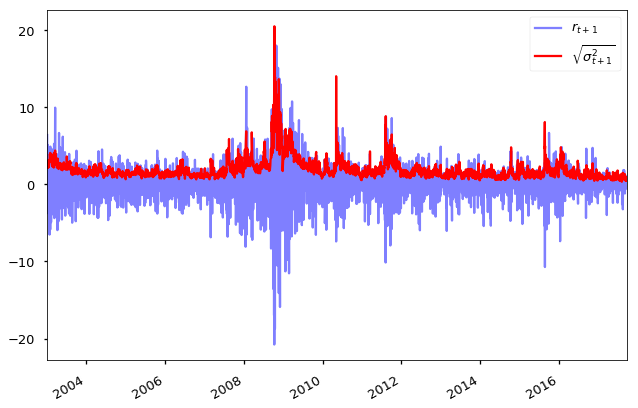

In [13]:
fig1, ax1 = mpl.pyplot.subplots()
data_for_plot['rtn'].plot(ax=ax1, color='blue', alpha=.5, label="$r_{t+1}$")
data_for_plot['vol'].apply(np.sqrt).plot(ax=ax1, label='$\sqrt{\sigma^2_{t+1}}$', color='red')
ax1.legend()
fig1.savefig('../doc/figures/time_series.tmp.pdf', frameon=False, pad_inches=0, bbox_inches='tight',
            transparent=True)

(None,)

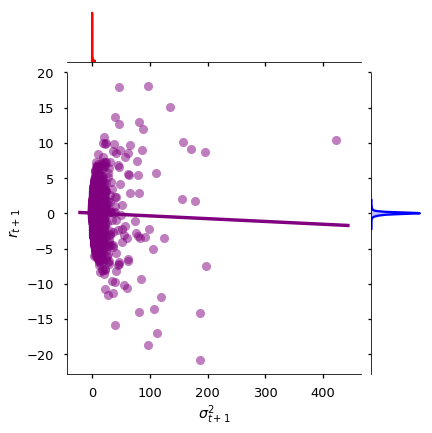

In [14]:
joint_grid = sns.JointGrid(x='vol', y='rtn', data=data_for_plot) #, xlim=[-.1, 3], ylim=[-2, 2])
joint_grid.plot_joint(sns.regplot, ci=None, color='purple', scatter_kws={"alpha":.5})
sns.kdeplot(data['vol'], ax=joint_grid.ax_marg_x, legend=None, shade=True, color='red')
sns.kdeplot(data['rtn'], ax=joint_grid.ax_marg_y, legend=None, shade=True, color='blue', vertical=True)
joint_grid.set_axis_labels("$\sigma^2_{t+1}$","$r_{t+1}$")
joint_grid.savefig('../doc/figures/joint_dist.tmp.pdf', frameon=False, pad_inches=0, bbox_inches='tight',
            transparent=True),

In [15]:
data_for_plot.describe()

,rtn,vol
count,3713.000000,3713.000000
mean,0.023421,5.621287
std,2.350165,14.458447
min,-20.781833,0.123335
25%,-0.954041,1.380618
50%,0.128299,2.416002
75%,1.099523,5.030940
max,18.031014,421.880784


In [16]:
stats.kurtosis(data_for_plot, fisher=False)

array([ 13.066, 243.401])

In [17]:
stats.skew(data_for_plot)

array([-0.312, 12.209])

In [18]:
data_for_plot.corr()

,rtn,vol
rtn,1.000000,-0.024379
vol,-0.024379,1.000000


## We now estimate the volatility paramters.

In [19]:
omega, omega_cov = vl.estimate_params_strong_id(data, bounds=bounds)

In [20]:
omega

{'gamma': 0.025965685942692017,
 'beta': 1.1135527707674138,
 'psi': -1.5373902507632273,
 'zeta': 0.9086856628806304,
 'log_both': -4.452601183471653,
 'log_scale': -3.484493100458501,
 'logit_rho': 1.2143874995349415,
 'phi': -0.30065789488617445,
 'pi': -22.779892676986957,
 'theta': 0.27932279776876157}

In [21]:
estimates, covariance = vl.estimate_params(data, *vl.compute_vol_gmm(data.vol))

In [22]:
estimates

{'gamma': 0.025965685942692017,
 'beta': 1.1135527707674138,
 'psi': -1.5373902507632273,
 'zeta': 0.9086856628806304,
 'log_both': -4.452601183471653,
 'log_scale': -3.484493100458501,
 'logit_rho': 1.2143874995349415}

## I compute the point estimates and confidence intervals for the volatility parameters.

### c

In [23]:
(100 * np.exp(estimates['log_scale']),
100 * np.exp(estimates['log_scale'] - 1.96 * covariance.loc['log_scale', 'log_scale']**.5),
 100 * np.exp(estimates['log_scale'] + 1.96 * covariance.loc['log_scale', 'log_scale']**.5))


(3.0669300744161987, 1.3843178480956426, 6.79472571584491)

### delta

In [24]:
log_mean = estimates['log_both'] - estimates['log_scale']
log_var = (covariance.loc['log_scale', 'log_scale'] + covariance.loc['log_both', 'log_both'] 
           - 2 * covariance.loc['log_scale', 'log_both'])
(100 * np.exp(log_mean),
 100 * np.exp(log_mean - 1.96 * log_var**.5),
 100 * np.exp(log_mean + 1.96 * log_var**.5)
)

(37.98009106060775, 17.652827343850205, 81.71423698168003)

### rho

In [25]:
mean = estimates['logit_rho']
std = covariance.loc['logit_rho', 'logit_rho']**.5
(special.expit(mean), special.expit(mean - 1.96 * std), special.expit(mean + 1.96*std))

(0.7710743457220686, 0.6747187511483863, 0.8454262029364638)

In [26]:
covariance

,beta,gamma,log_both,log_scale,logit_rho,psi,zeta
beta,0.009748,-0.000035,0.000000,0.000000,0.000000,-0.009132,0.000000
gamma,-0.000035,0.000006,0.000000,0.000000,0.000000,-0.000080,0.000000
log_both,0.000000,0.000000,0.020524,0.016218,-0.031927,0.000000,0.000000
log_scale,0.000000,0.000000,0.016218,0.164716,0.005152,0.000000,0.000000
logit_rho,0.000000,0.000000,-0.031927,0.005152,0.061176,0.000000,0.000000
psi,-0.009132,-0.000080,0.000000,0.000000,0.000000,0.014926,0.000000
zeta,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000431


In [27]:
data.vol.sort_values(ascending=True).head()

2017-08-07    0.001233
2017-09-14    0.002147
2017-09-22    0.002169
2016-11-25    0.002262
2017-07-24    0.002427
Name: vol, dtype: float64

In [28]:
omega2, omega_cov2 = vl.estimate_params(data)

In [29]:
qlr_stats = vl.compute_qlr_stats(omega=omega2, omega_cov=omega_cov2, bounds=bounds,use_tqdm=True)

In [30]:
qlr_draws = vl.compute_qlr_sim(omega=omega2, omega_cov=omega_cov2, bounds=bounds, use_tqdm=True,
                               alpha=0.05, innov_dim=10)

In [31]:
qlr_draws.head()

,phi,pi,theta,qlr
3,-0.4,-35.0,0.0,inf
15,-0.4,-35.0,0.1,inf
2,-0.4,-35.0,0.2,inf
4,-0.4,-35.0,0.3,inf
0,-0.4,-35.0,0.4,inf


In [32]:
qlr_draws.head()

,phi,pi,theta,qlr
3,-0.4,-35.0,0.0,inf
15,-0.4,-35.0,0.1,inf
2,-0.4,-35.0,0.2,inf
4,-0.4,-35.0,0.3,inf
0,-0.4,-35.0,0.4,inf


In [33]:
qlr_stats.count()

phi      2048
pi       2048
theta    2048
qlr      2048
dtype: int64

In [34]:
merged_values = vl.merge_draws_and_sims(qlr_stats, qlr_draws)

In [35]:
merged_values.head()

,phi,pi,theta,qlr_draws,qlr_stats
0,-0.4,-35.0,0.5,inf,inf
1,-0.4,-35.0,0.2,inf,inf
2,-0.4,-35.0,1.2,inf,inf
3,-0.4,-35.0,0.4,inf,inf
4,-0.4,-35.0,1.1,inf,inf


In [36]:
accepted_vals = merged_values.query('qlr_stats < qlr_draws').drop(['qlr_draws', 'qlr_stats'], axis='columns')

In [37]:
qlr_draws.to_json(f'../results/qlr_draws_on_data_{innov_dim}_smaller_region_flattened.tmp.json')

In [38]:
qlr_draws = pd.read_json(f'../results/qlr_draws_on_data_{innov_dim}_smaller_region_flattened.tmp.json')

In [39]:
qlr2_draws = qlr_draws.copy()
qlr2_draws[qlr2_draws >= stats.chi2.ppf(df=4, q=.95)]  = stats.chi2.ppf(df=4, q=.95)

In [40]:
qlr2_draws.head(100)

,phi,pi,theta,qlr
0,-0.400000,-35.000000,0.4,NaN
1,-0.400000,-35.000000,0.5,NaN
10,-0.400000,-35.000000,1.2,NaN
100,-0.400000,-21.000000,0.6,9.487729
1000,-0.292857,-2.333333,0.8,9.487729
1001,-0.292857,-2.333333,0.9,9.487729
1002,-0.292857,-2.333333,1.2,9.487729
1003,-0.292857,-2.333333,1.3,9.487729
1004,-0.292857,-2.333333,1.0,9.487729
1005,-0.292857,-2.333333,1.1,9.487729


In [41]:
def constraint(scale, psi, zeta, equity_price):
    
    vol_price  = -1 / scale - ((psi * (equity_price-1) + zeta/2 * (equity_price-1)**2))
    
    return  vol_price

In [42]:
ar_stats = vl.compute_ar_stats(omega2, omega_cov2, bounds)

In [43]:
ar_accepted_vals = ar_stats[ar_stats.AR <= stats.chi2.ppf(df=4, q=.95)]

In [44]:
qlr_stats.head()

,phi,pi,theta,qlr
1,-0.4,-35.0,0.5,inf
2,-0.4,-35.0,0.2,inf
10,-0.4,-35.0,1.2,inf
0,-0.4,-35.0,0.4,inf
9,-0.4,-35.0,1.1,inf


In [45]:
pd.merge(qlr2_draws.sort_values(by=['phi', 'pi', 'theta']),
           qlr_stats.sort_values(by=['phi', 'pi', 'theta']),
        left_on=['phi', 'pi', 'theta'], right_on=['phi','pi','theta'], suffixes=['_draws', '_stats'])

,phi,pi,theta,qlr_draws,qlr_stats
0,-0.40,-35.0,0.0,NaN,inf
1,-0.40,-35.0,0.1,NaN,inf
2,-0.40,-35.0,0.2,NaN,inf
3,-0.40,-35.0,0.3,NaN,inf
4,-0.40,-35.0,0.4,NaN,inf
5,-0.40,-35.0,0.5,NaN,inf
6,-0.40,-35.0,0.6,NaN,inf
7,-0.40,-35.0,0.7,NaN,inf
8,-0.40,-35.0,0.8,NaN,inf
9,-0.40,-35.0,0.9,NaN,inf


In [46]:
qlr_stats.phi[1000]

-0.29285714285714287

In [47]:
qlr_stats[np.all(np.isclose(qlr_stats.loc[:, ['phi', 'pi']], [-.292857, -11.666667]), axis=1)]

,phi,pi,theta,qlr
930,-0.292857,-11.666667,0.2,77.600071
928,-0.292857,-11.666667,0.0,16.040227
931,-0.292857,-11.666667,0.5,11.099009
932,-0.292857,-11.666667,0.4,7.393675
929,-0.292857,-11.666667,0.1,3.860571
935,-0.292857,-11.666667,0.8,4.110570
937,-0.292857,-11.666667,1.0,5.755481
933,-0.292857,-11.666667,0.6,8.832378
936,-0.292857,-11.666667,0.3,13.377175
934,-0.292857,-11.666667,0.7,19.424121


In [48]:
qlr_stats.query('phi == -0.29285714285714287').sort_values(by='qlr').head(50).tail()

,phi,pi,theta,qlr
918,-0.292857,-14.000000,0.5,5.858622
949,-0.292857,-9.333333,0.3,5.879978
948,-0.292857,-9.333333,0.7,6.180087
900,-0.292857,-16.333333,0.6,6.194795
836,-0.292857,-25.666667,0.5,6.221913


In [49]:
qlr_stats.query('5 < qlr < 9').sort_values(by='qlr').head(10)

,phi,pi,theta,qlr
610,-0.328571,-21.000000,0.2,5.008527
1106,-0.257143,-23.333333,0.1,5.011134
1140,-0.257143,-18.666667,0.6,5.035681
1359,-0.221429,-25.666667,1.3,5.114239
613,-0.328571,-21.000000,0.4,5.130566
677,-0.328571,-11.666667,0.4,5.130595
1060,-0.257143,-30.333333,0.4,5.143583
376,-0.364286,-18.666667,0.9,5.218606
408,-0.364286,-14.000000,0.8,5.235305
356,-0.364286,-21.000000,0.3,5.327981


In [50]:
qlr_draws.query('5 < qlr < 9').sort_values(by='qlr').head(10)

,phi,pi,theta,qlr
680,-0.328571,-11.666667,0.8,5.044480
947,-0.292857,-9.333333,0.5,5.085003
936,-0.292857,-11.666667,0.3,5.220494
1154,-0.257143,-16.333333,0.1,5.225846
952,-0.292857,-9.333333,0.4,5.248838
675,-0.328571,-11.666667,0.5,5.381384
408,-0.364286,-14.000000,0.8,5.399185
576,-0.328571,-25.666667,0.0,5.479587
1157,-0.257143,-16.333333,0.3,5.504868
664,-0.328571,-14.000000,0.8,5.571991


In [51]:
qlr2_draws[np.isclose(qlr2_draws.phi, -0.292857) * qlr2_draws.qlr > 0].sort_values(by='qlr')

,phi,pi,theta,qlr
866,-0.292857,-21.000000,0.2,0.366975
876,-0.292857,-21.000000,1.3,0.669842
882,-0.292857,-18.666667,0.3,0.821353
885,-0.292857,-18.666667,0.4,1.095804
869,-0.292857,-21.000000,0.6,1.779556
881,-0.292857,-18.666667,0.2,1.839966
867,-0.292857,-21.000000,0.1,1.941912
849,-0.292857,-23.333333,0.0,2.067706
901,-0.292857,-16.333333,0.4,2.156793
902,-0.292857,-16.333333,0.3,2.224924


In [52]:
qlr_draws[qlr2_draws.qlr > 0].sort_values(by='qlr').head(20)

,phi,pi,theta,qlr
1105,-0.257143,-23.333333,0.5,0.168666
866,-0.292857,-21.000000,0.2,0.366975
626,-0.328571,-18.666667,0.5,0.503370
108,-0.400000,-21.000000,0.8,0.606897
876,-0.292857,-21.000000,1.3,0.669842
882,-0.292857,-18.666667,0.3,0.821353
613,-0.328571,-21.000000,0.4,1.055751
885,-0.292857,-18.666667,0.4,1.095804
1349,-0.221429,-25.666667,0.5,1.365611
644,-0.328571,-16.333333,0.6,1.696889


In [53]:
qlr2_draws.head()

,phi,pi,theta,qlr
0,-0.400000,-35.000000,0.4,NaN
1,-0.400000,-35.000000,0.5,NaN
10,-0.400000,-35.000000,1.2,NaN
100,-0.400000,-21.000000,0.6,9.487729
1000,-0.292857,-2.333333,0.8,9.487729


In [54]:
qlr2_draws.sort_values(by=['phi', 'pi', 'theta'])

,phi,pi,theta,qlr
3,-0.40,-35.000000,0.0,NaN
15,-0.40,-35.000000,0.1,NaN
2,-0.40,-35.000000,0.2,NaN
4,-0.40,-35.000000,0.3,NaN
0,-0.40,-35.000000,0.4,NaN
1,-0.40,-35.000000,0.5,NaN
7,-0.40,-35.000000,0.6,NaN
23,-0.40,-35.000000,0.7,NaN
5,-0.40,-35.000000,0.8,NaN
6,-0.40,-35.000000,0.9,NaN


In [55]:
qlr_stats.sort_values(by=['phi', 'pi', 'theta'])

,phi,pi,theta,qlr
3,-0.40,-35.000000,0.0,inf
15,-0.40,-35.000000,0.1,inf
2,-0.40,-35.000000,0.2,inf
4,-0.40,-35.000000,0.3,inf
0,-0.40,-35.000000,0.4,inf
1,-0.40,-35.000000,0.5,inf
7,-0.40,-35.000000,0.6,inf
23,-0.40,-35.000000,0.7,inf
5,-0.40,-35.000000,0.8,inf
6,-0.40,-35.000000,0.9,inf


In [56]:
qlr2_draws.head()

,phi,pi,theta,qlr
0,-0.400000,-35.000000,0.4,NaN
1,-0.400000,-35.000000,0.5,NaN
10,-0.400000,-35.000000,1.2,NaN
100,-0.400000,-21.000000,0.6,9.487729
1000,-0.292857,-2.333333,0.8,9.487729


In [59]:
ar_accepted_vals.min()

phi      -0.364286
pi      -30.333333
theta     0.000000
AR        0.389386
dtype: float64

In [60]:
ar_accepted_vals.max()

phi     -0.221429
pi       0.000000
theta    1.200000
AR       9.482561
dtype: float64

In [61]:
accepted_vals.min()

phi      -0.400000
pi      -30.333333
theta     0.000000
dtype: float64

In [62]:
accepted_vals.max()

phi     -0.15
pi       0.00
theta    1.50
dtype: float64

In [63]:
accepted_vals.head()

,phi,pi,theta
32,-0.4,-30.333333,0.7
33,-0.4,-30.333333,0.1
34,-0.4,-30.333333,0.6
35,-0.4,-30.333333,0.3
36,-0.4,-30.333333,0.9


In [65]:
accepted_vals.min()

phi      -0.400000
pi      -30.333333
theta     0.000000
dtype: float64

In [66]:
bounds

{'pi': {'max': 0, 'min': -35, 'dim': 16},
 'phi': {'max': -0.15, 'min': -0.4, 'dim': 8},
 'theta': {'max': 1.5, 'min': 0, 'dim': 16}}

In [67]:
accepted_vals.max()

phi     -0.15
pi       0.00
theta    1.50
dtype: float64

In [68]:
bounds

{'pi': {'max': 0, 'min': -35, 'dim': 16},
 'phi': {'max': -0.15, 'min': -0.4, 'dim': 8},
 'theta': {'max': 1.5, 'min': 0, 'dim': 16}}

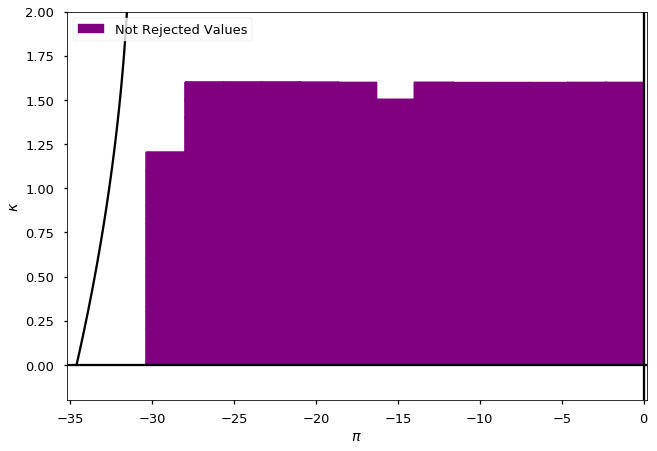

In [69]:
fig3, ax3 = mpl.pyplot.subplots()
pi_patch_width = 1.1 * (bounds['pi']['max'] - bounds['pi']['min']) / bounds['pi']['dim']
theta_patch_height = 1.1 * (bounds['theta']['max'] - bounds['theta']['min']) / bounds['theta']['dim']
for row in accepted_vals.itertuples(index=False):
#     print(row)
    patch = mpl.patches.Rectangle((row.pi, row.theta), width=pi_patch_width, height=theta_patch_height,
                                  fill=True, color='purple')
    ax3.add_patch(patch)
# ax3.scatter(y=accepted_vals.theta, x=accepted_vals.pi, marker='s', s=650, label='Not Rejected Values',
#            color='purple')

max_y = bounds['theta']['max']
min_x = bounds['pi']['min']

yvals = np.linspace(0,max_y+1,100)
xvals = [constraint(np.exp(omega['log_scale']), omega['psi'], omega['zeta'], x) for x in yvals]
ax3.plot(xvals, yvals, color='black', label='Constraint')
ax3.axvline(0,  ymin=0, ymax=1, color='black')
ax3.axhline(0,  xmin=1, xmax=0, color='black')

white_rect1 = mpl.patches.Rectangle((0,-1), 2, max_y + 2, angle=0.0, color='white', fill=True)
white_rect2 = mpl.patches.Rectangle((min_x-1,-1), abs(min_x) + 2, 1, angle=0.0, color='white', fill=True)
ax3.add_patch(white_rect1)
ax3.add_patch(white_rect2)
ax3.set_ylim([-.2, max_y+.5])
ax3.set_xlim([min_x - .2, .2])
ax3.set_ylabel(r'$\kappa$')
ax3.set_xlabel(r'$\pi$')
ax3.legend(handles=[patch], labels=['Not Rejected Values'], loc='upper left')

fig3.savefig(f'../doc/figures/confidence_region_{innov_dim}.tmp.pdf', frameon=False, pad_inches=0, 
             bbox_inches='tight', transparent=True)

In [70]:
qlr_draws_pivoted = qlr_draws[np.isclose(qlr_draws.phi, accepted_vals.phi.value_counts().argmax())].drop(columns=['phi']).pivot(
    columns='pi',index='theta', values='qlr').sort_index(by='theta', ascending=False)

In [71]:
stats.chi2.ppf(.95, df=4)

9.487729036781154

In [72]:
qlr2_draws_pivoted = qlr2_draws[np.isclose(qlr2_draws.phi, accepted_vals.phi.value_counts().argmax())].drop(columns=['phi']).pivot(
    columns='pi',index='theta', values='qlr').sort_index(by='theta', ascending=False)

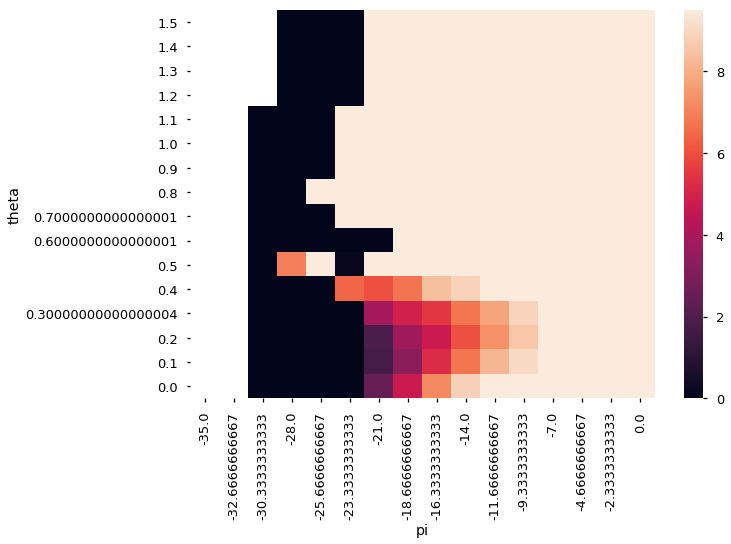

In [73]:
sns.heatmap(qlr2_draws_pivoted)

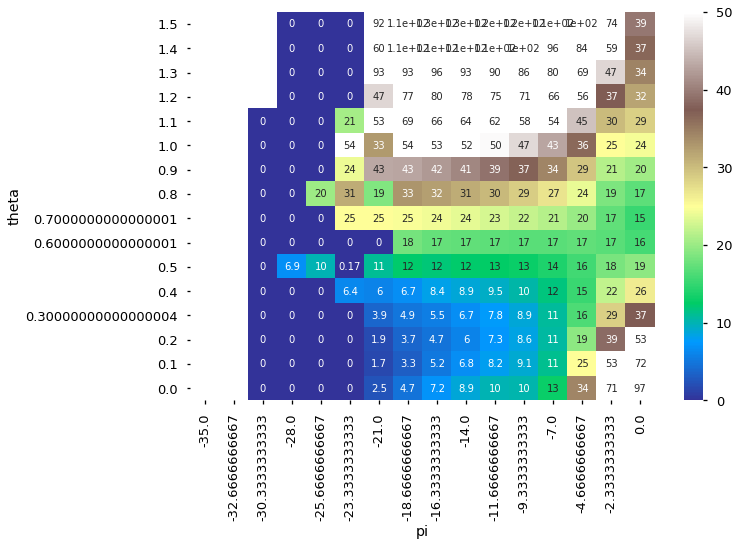

In [74]:
sns.heatmap(qlr_draws_pivoted, annot=True,  cmap=mpl.cm.get_cmap('terrain'), vmin=0, vmax=50)

In [75]:
qlr_draws_pivoted.head()

pi,-35.0,-32.6666666667,-30.3333333333,-28.0,-25.6666666667,-23.3333333333,-21.0,-18.6666666667,-16.3333333333,-14.0,-11.6666666667,-9.3333333333,-7.0,-4.6666666667,-2.3333333333,0.0
theta,,,,,,,,,,,,,,,,
1.5,NaN,NaN,NaN,0.0,0.0,0.000000,91.949556,111.005699,127.920425,125.166540,124.005148,120.827359,113.740266,101.028645,74.028008,39.497933
1.4,NaN,NaN,NaN,0.0,0.0,0.000000,59.515312,113.923150,111.131305,110.391516,107.232424,102.645396,95.861927,83.841572,58.978649,36.592208
1.3,NaN,NaN,NaN,0.0,0.0,0.000000,92.924658,92.995899,96.008136,92.664798,90.176359,86.051644,79.887897,68.865956,46.850312,34.486471
1.2,NaN,NaN,NaN,0.0,0.0,0.000000,46.701991,76.756400,79.889244,78.095075,75.071602,71.369463,65.786128,56.044036,37.399793,31.955089
1.1,NaN,NaN,0.0,0.0,0.0,20.659401,53.013156,68.602639,66.441269,63.754937,61.500357,58.305986,53.517226,45.280641,30.272805,28.548754


In [76]:
qlr_stats_pivoted = qlr_stats[np.isclose(qlr_stats.phi, accepted_vals.phi.value_counts().argmax())].drop(columns=['phi']).pivot(
    columns='pi',index='theta', values='qlr').sort_index(axis='index').sort_index(by='theta', ascending=False)

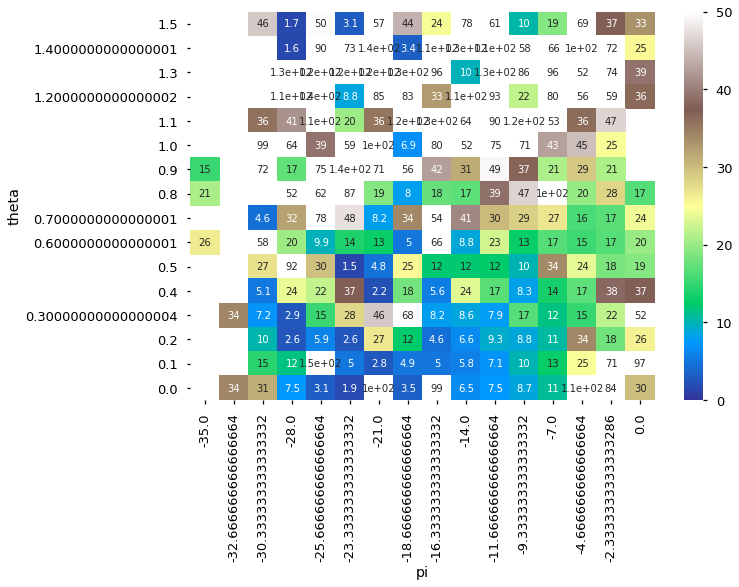

In [78]:
sns.heatmap(qlr_stats_pivoted, annot=True, cmap=mpl.cm.get_cmap('terrain'), vmin=0, vmax=50)